**Résolution d'une équation de Poisson**

Compiling model...
'compile' took 0.000140 s

Training model...

0         [4.29e+01, 9.51e-02]    [4.85e+01, 9.51e-02]    [8.14e-01]    


Epoch 1: train loss improved from inf to 4.30e+01, saving model to model/model-1.pt ...

1000      [1.82e-04, 5.09e-08]    [2.26e-04, 5.09e-08]    [2.05e-04]    
Epoch 1000: train loss improved from 4.30e+01 to 1.82e-04, saving model to model/model-1000.pt ...

2000      [5.46e-06, 1.10e-09]    [1.31e-05, 1.10e-09]    [5.56e-05]    
Epoch 2000: train loss improved from 1.82e-04 to 5.46e-06, saving model to model/model-2000.pt ...

3000      [1.35e-05, 1.97e-07]    [1.68e-05, 1.97e-07]    [4.34e-04]    
4000      [4.28e-06, 2.25e-10]    [1.34e-05, 2.25e-10]    [3.47e-05]    
Epoch 4000: train loss improved from 5.46e-06 to 4.28e-06, saving model to model/model-4000.pt ...

5000      [1.38e-03, 1.03e-04]    [1.29e-03, 1.03e-04]    [1.16e-02]    
6000      [1.48e-03, 6.06e-05]    [1.67e-03, 6.06e-05]    [1.11e-02]    
7000      [2.04e-05, 3.37e-06]    [4.51e-05, 3.37e-06]    [1.93e-03]    
8000      [6.32e-04, 9.24e-05]    [6.68e-04, 9.24e-05]    [9.13e-03]    
9000      [5.02e-04, 9.89e-

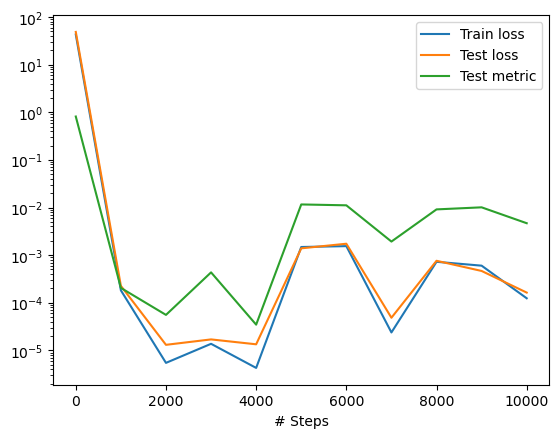

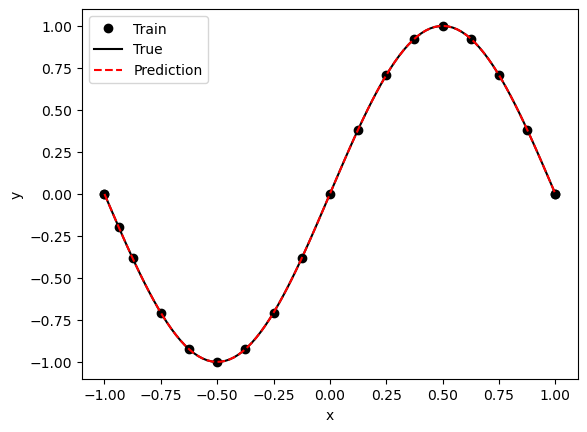

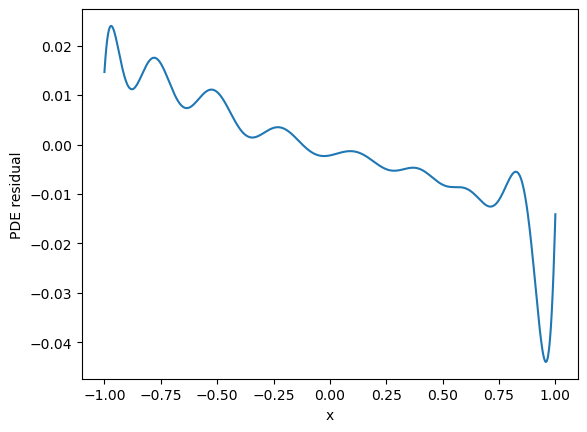

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import torch
# Import torch if using backend pytorch
# import torch
# Import jax.numpy if using backend jax
# import jax.numpy as jnp
# Import paddle if using backend paddle
# import paddle


def pde(x, y):
    # Most backends
    dy_xx = dde.grad.hessian(y, x)
    # Backend jax
    # dy_xx, _ = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    # Use torch.sin for backend pytorch
    return -dy_xx - np.pi ** 2 * torch.sin(np.pi * x)
    # Use jax.numpy.sin for backend jax
    # return -dy_xx - np.pi ** 2 * jnp.sin(np.pi * x)
    # Use paddle.sin for backend paddle
    # return -dy_xx - np.pi ** 2 * paddle.sin(np.pi * x)


def boundary(x, on_boundary):
    return on_boundary


def func(x):
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

# Optional: Save the model during training.
checkpointer = dde.callbacks.ModelCheckpoint(
     "model/model", verbose=1, save_better_only=True
)

losshistory, train_state = model.train(iterations=10000, callbacks=[checkpointer,])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

**Transfer Learning** : On utilise le modèle déjà entraîné pour résoudre un problème simillaire du précédent

Par exemple ici On change les conditions au bord

Compiling model...
'compile' took 0.000179 s

Restoring model from model/model-4000.pt ...

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.28e-06, 1.30e+01]    [1.34e-05, 1.30e+01]    [9.25e-01]    


/users/eleves-b/2022/issame.maghraoui/.local/lib/python3.9/site-packages/deepxde/model.py:1096: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_pa

50        [1.54e-01, 3.11e-03]    [6.05e-02, 3.11e-03]    [8.74e-03]    

Best model at step 50:
  train loss: 1.57e-01
  test loss: 6.36e-02
  test metric: [8.74e-03]

'train' took 0.252002 s

Saving loss history to /users/eleves-b/2022/issame.maghraoui/Transer_Learning/loss.dat ...
Saving training data to /users/eleves-b/2022/issame.maghraoui/Transer_Learning/train.dat ...
Saving test data to /users/eleves-b/2022/issame.maghraoui/Transer_Learning/test.dat ...


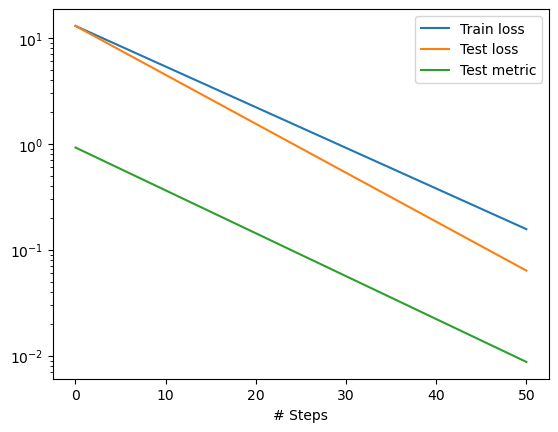

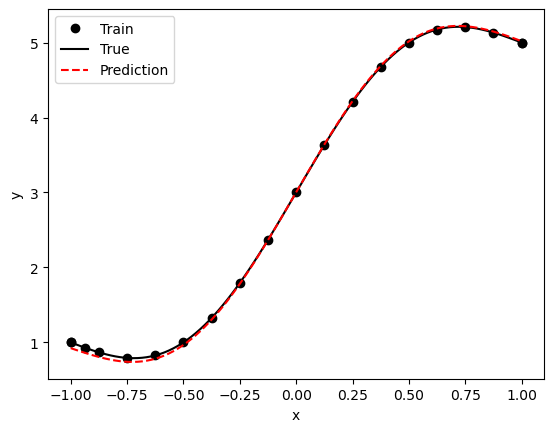

In [15]:
def func2(x):
    return np.sin(np.pi * x) + 2*x + 3
bc2 = bc = dde.icbc.DirichletBC(geom, func2, boundary)
data2 = dde.data.PDE(geom, pde, bc2, 16, 2, solution=func2, num_test=100)
model2 = dde.Model(data2, net)
model2.compile("adam", lr=0.001, metrics=["l2 relative error"])
model2.restore(f"model/model-{train_state.best_step}.pt", verbose=1)
losshistory2, train_state2 = model2.train(iterations=50)

dde.saveplot(losshistory2, train_state2, issave=True, isplot=True)

